<a href="https://colab.research.google.com/github/Master-Ramjhith/Predict-UFC-Fight-Outcomes/blob/main/Predict_UFC_Fight_Outcomes_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Applying Machine Learning Algorithms to Predict UFC Fight  Outcomes**
<br>
Problem Number: 74
<br>
Team: V C RAMJHITH - PES1UG23CS662
<br>
Tanya Tripathi - PES1UG23CS638
<br>
Dataset Used: UFC 1994-2025 <br>

In [22]:
# Uploading The Dataset Manually: ufc_dataset.csv manually presented in GitHub
from google.colab import files
uploaded = files.upload()

In [23]:
# Pre-requirements
!pip install -q lightgbm xgboost catboost

Dataset loaded: 1477 samples, 895 columns.
Processed features: 1310
Train/Test split: 1181/296
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.551749	valid_0's binary_logloss: 0.682792
Early stopping, best iteration is:
[1]	valid_0's auc: 0.610933	valid_0's binary_logloss: 0.690853

--- Model Comparison ---
                 Model  Accuracy  F1 Score       AUC   Time (s)
1        RandomForest  0.601351  0.702020  0.584181   1.502703
2             XGBoost  0.574324  0.675258  0.580672   6.083076
4            CatBoost  0.611486  0.713217  0.571933  46.941106
0  LogisticRegression  0.506757  0.560241  0.519031   1.607645
3            LightGBM  0.540541  0.649485  0.508550   2.852254

FINAL SUMMARY REPORT
Data Samples: 1,477
Processed Features: 1310
Target Distribution (Red Wins=1): 58.7%
Total Runtime: 61.1s
----------------------------------------
Best Model: RandomForest
Test Accuracy: 0.601
Test F1 Score: 0.702
Test AUC Score: 0.584

Classification Rep

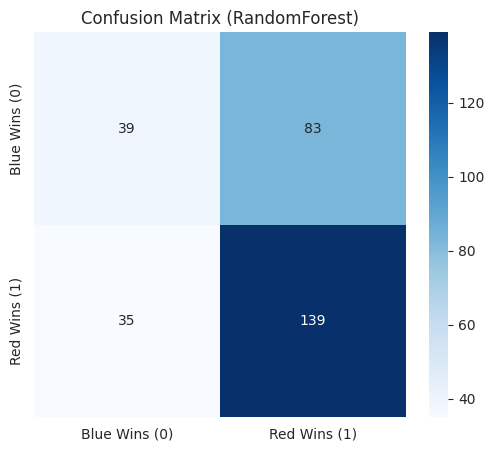

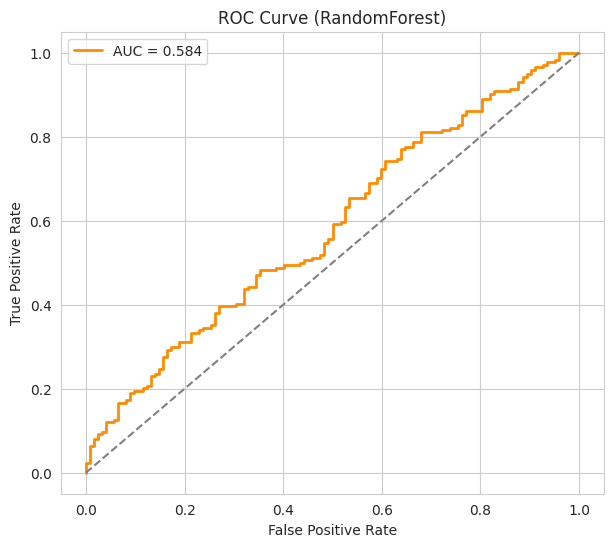

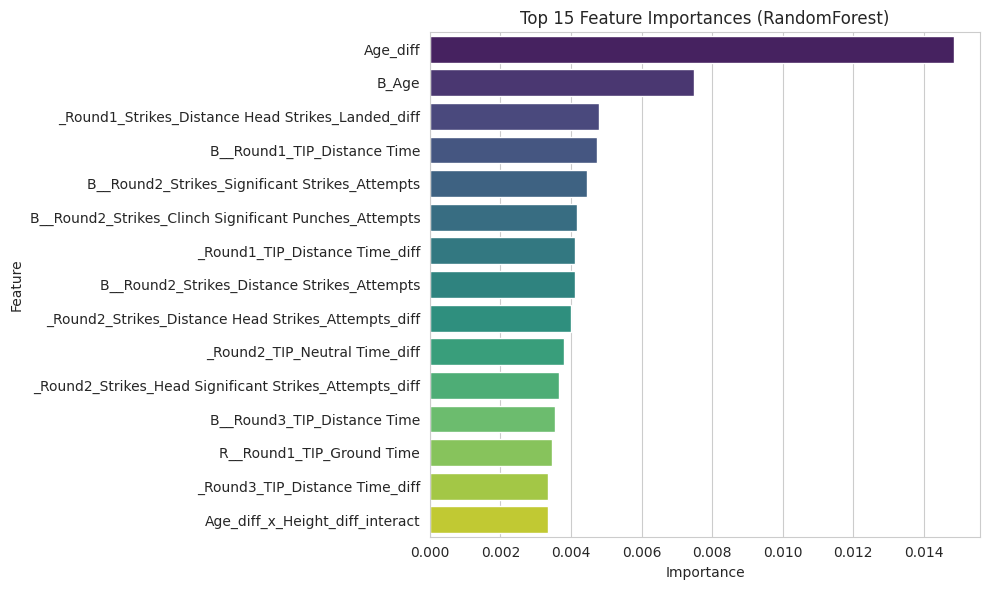

In [25]:
# === UFC Fight Outcome Prediction Project ===
# Applies 5 ML models and selects best model for prediction
import warnings, time
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from catboost import CatBoostClassifier

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
RANDOM_STATE = 42
TEST_SIZE = 0.2

# ------------------ Load & Prepare Data ------------------
t0 = time.time()
df = pd.read_csv("ufc_dataset.csv")
print(f"Dataset loaded: {df.shape[0]} samples, {df.shape[1]} columns.")

# Identify target column
target_col = next((c for c in df.columns if c.lower() in ['winner','target','result']), 'target')
df[target_col] = df[target_col].astype(str).str.lower().apply(lambda x: 1 if 'red' in x else 0)
y = df[target_col]

# Drop identifiers/text columns
DROP_COLS = [c for c in df.columns if any(x in c.lower() for x in ['name','id','hometown','location','date','fight_']) and c != target_col]
X = df.drop(columns=[target_col]+DROP_COLS, errors='ignore')

# ------------------ Feature Engineering ------------------
def create_diff_interaction(df):
    df_new = df.copy()
    num_cols = df_new.select_dtypes(include=[np.number]).columns
    diff_cols = []
    for c in num_cols:
        if c.startswith("B_"):
            r_col = "R_" + c[2:]
            if r_col in num_cols:
                diff_col = c[2:] + "_diff"
                df_new[diff_col] = df_new[r_col] - df_new[c]
                diff_cols.append(diff_col)
    if len(diff_cols)>=2:
        df_new[f'{diff_cols[0]}_x_{diff_cols[1]}_interact'] = df_new[diff_cols[0]] * df_new[diff_cols[1]]
    return df_new

X = create_diff_interaction(X)
NUM_COLS = X.select_dtypes(include=[np.number]).columns.tolist()
CAT_COLS = [c for c in X.select_dtypes(include=['object','category']).columns if 1 < X[c].nunique() <= 50]

# ------------------ Preprocessing ------------------
OHE = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
NUM_PIPE = Pipeline([("imputer", SimpleImputer(strategy='median')),("scaler", StandardScaler())])
CAT_PIPE = Pipeline([("imputer", SimpleImputer(strategy='constant', fill_value="MISSING")),("onehot", OHE)])
PREPROCESSOR = ColumnTransformer([("num",NUM_PIPE,NUM_COLS),("cat",CAT_PIPE,CAT_COLS)], sparse_threshold=0)
X_proc = PREPROCESSOR.fit_transform(X)
print(f"Processed features: {X_proc.shape[1]}")

# ------------------ Train/Test Split ------------------
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"Train/Test split: {X_train.shape[0]}/{X_test.shape[0]}")

# ------------------ Models ------------------
MODELS = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=7, random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.05, eval_metric='logloss', use_label_encoder=False, n_jobs=-1, random_state=RANDOM_STATE),
    "LightGBM": LGBMClassifier(n_estimators=800, max_depth=7, num_leaves=40, learning_rate=0.03, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.2, reg_lambda=0.2, n_jobs=-1, random_state=RANDOM_STATE, class_weight='balanced', verbose=-1),
    "CatBoost": CatBoostClassifier(iterations=300, depth=7, learning_rate=0.05, verbose=0, random_state=RANDOM_STATE)
}

# ------------------ Model Comparison ------------------
results=[]
for name, model in MODELS.items():
    start = time.time()
    if name=="LightGBM":
        X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_STATE, stratify=y_train)
        model.fit(X_tr, y_tr, eval_set=[(X_val,y_val)], eval_metric='auc', callbacks=[early_stopping(stopping_rounds=50), log_evaluation(50)])
    else:
        model.fit(X_train, y_train)
    end = time.time()
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model,"predict_proba") else y_pred
    results.append([name, accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), roc_auc_score(y_test, y_prob), end-start])

perf_df = pd.DataFrame(results, columns=["Model","Accuracy","F1 Score","AUC","Time (s)"]).sort_values(by="AUC", ascending=False)
print("\n--- Model Comparison ---\n", perf_df)

# ------------------ Select Best Model ------------------
best_model_name = perf_df.iloc[0]["Model"]
best_model = MODELS[best_model_name]
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:,1] if hasattr(best_model,"predict_proba") else y_pred

# ------------------ Summary Report ------------------
total_time = time.time() - t0
print("\n" + "="*40)
print("FINAL SUMMARY REPORT")
print("="*40)
print(f"Data Samples: {df.shape[0]:,}")
print(f"Processed Features: {X_proc.shape[1]}")
print(f"Target Distribution (Red Wins=1): {y.mean():.1%}")
print(f"Total Runtime: {total_time:.1f}s")
print("-"*40)
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Test F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"Test AUC Score: {roc_auc_score(y_test, y_prob):.3f}")
print("="*40)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Blue Wins (0)','Red Wins (1)']))

# ------------------ Confusion Matrix ------------------
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Blue Wins (0)','Red Wins (1)'], yticklabels=['Blue Wins (0)','Red Wins (1)'])
plt.title(f"Confusion Matrix ({best_model_name})")
plt.show()

# ------------------ ROC Curve ------------------
plt.figure(figsize=(7,6))
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}", lw=2, color='darkorange')
plt.plot([0,1],[0,1],'k--',color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve ({best_model_name})"); plt.legend(); plt.show()

# ------------------ Top 15 Feature Importances ------------------
if hasattr(best_model,"feature_importances_"):
    feature_names = NUM_COLS + list(PREPROCESSOR.named_transformers_['cat']['onehot'].get_feature_names_out(CAT_COLS))
    top15 = pd.Series(best_model.feature_importances_, index=feature_names).sort_values(ascending=False).head(15)
    plt.figure(figsize=(10,6))
    sns.barplot(x=top15.values, y=top15.index, palette="viridis")
    plt.title(f"Top 15 Feature Importances ({best_model_name})")
    plt.xlabel("Importance"); plt.ylabel("Feature")
    plt.tight_layout(); plt.show()
